In [7]:
%matplotlib inline
import numpy as np
from skimage.io import imshow
from skimage.measure import label
from scipy.ndimage import distance_transform_edt

def generate_random_circles(n = 100, d = 256):
    circles = np.random.randint(0, d, (n, 3))
    x = np.zeros((d, d), dtype=int)
    
    for x0, y0, r in circles:
        x += np.fromfunction(lambda x, y: ((x - x0)**2 + (y - y0)**2) <= (r/d*10)**2, x.shape)
    x = np.clip(x, 0, 1)

    return x


In [8]:
def unet_weight_map(y, wc=None, w0 = 10, sigma = 5):

    """
    Generate weight maps as specified in the U-Net paper
    for boolean mask.
    
    "U-Net: Convolutional Networks for Biomedical Image Segmentation"
    https://arxiv.org/pdf/1505.04597.pdf
    
    Parameters
    ----------
    mask: Numpy array
        2D array of shape (image_height, image_width) representing binary mask
        of objects.
    wc: dict
        Dictionary of weight classes.
    w0: int
        Border weight parameter.
    sigma: int
        Border width parameter.

    Returns
    -------
    Numpy array
        Training weights. A 2D array of shape (image_height, image_width).
    """
    
    labels = label(y)
    no_labels = labels == 0
    label_ids = sorted(np.unique(labels))[1:]

    if len(label_ids) > 1:
        distances = np.zeros((y.shape[0], y.shape[1], len(label_ids)))

        for i, label_id in enumerate(label_ids):
            distances[:,:,i] = distance_transform_edt(labels != label_id)

        distances = np.sort(distances, axis=2)
        d1 = distances[:,:,0]
        d2 = distances[:,:,1]
        w = w0 * np.exp(-1/2*((d1 + d2) / sigma)**2) * no_labels
        
        if wc:
            class_weights = np.zeros_like(y)
            for k, v in wc.items():
                class_weights[y == k] = v
            w = w + class_weights
    else:
        w = np.zeros_like(y)
    
    return w

In [9]:
y = generate_random_circles()

In [10]:
wc = {
    0: 1, # background
    1: 5  # objects
}

w = unet_weight_map(y, wc)

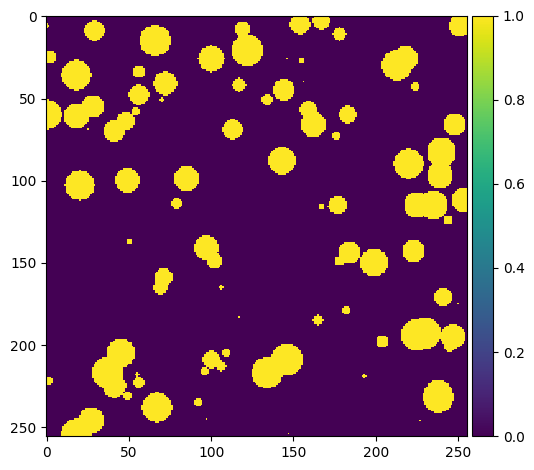

In [11]:
imshow(y)

e:\my_project\first\venv\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:149: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


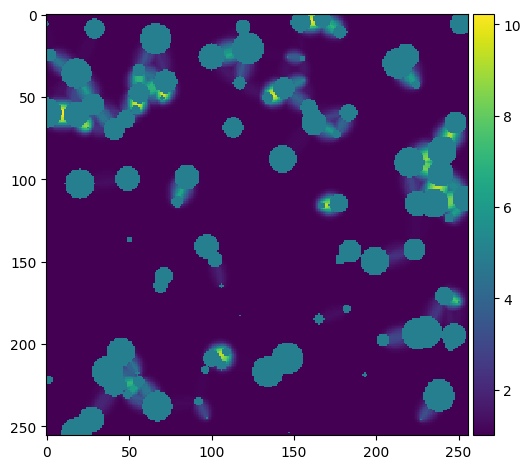

In [12]:
imshow(w)